<a href="https://colab.research.google.com/github/AlejoArav/BIO266E/blob/master/GoogleColab/patronesturing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patrones espaciales

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import numba as nb
import os

# Ecuaciones modificadas del sistema de Turing

$$
\begin{align}
\frac{\partial u }{\partial t} &= D_u \nabla^2 u + f(u,v) \\
\frac{\partial v }{\partial t} &= D_v \nabla^2 v + g(u,v)
\end{align}
$$

Donde $f(u,v)$ y $g(u,v)$ son funciones no lineales que describen la interacción entre las dos especies. En este caso, se utilizarán las siguientes funciones:

$$
\begin{align}
f(u,v) &= \alpha(u - h) + \beta(v - k) \\
g(u,v) &= \gamma(u - h) - \epsilon(v - k)
\end{align}
$$

Donde $\alpha$, $\beta$, $\gamma$, $\epsilon$, $h$ y $k$ son constantes. Para este caso, se utilizarán los siguientes valores:

$$
\begin{align}
\alpha &= 1.0 \\
\beta &= -1.0 \\
\gamma &= 2.0 \\
\epsilon &= -1.5 \\
h &= 1.0 \\
k &= 1.0 \\
D_u &= 10^{-4} \\
D_v &= 10^{-3}
\end{align}
$$

Ahora podemos escribir las ecuaciones completas del sistema:

$$
\begin{align}
\frac{\partial u }{\partial t} &= D_u \nabla^2 u + u(v - 1) - \alpha \\
\frac{\partial v }{\partial t} &= D_v \nabla^2 v + \beta - uv
\end{align}
$$

## Cálculo del laplaciano en dos dimensiones

Para calcular el laplaciano en dos dimensiones, se utiliza la siguiente aproximación:

$$
\begin{align}
\nabla^2 u &= \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}}{h^2} \\
\nabla^2 v &= \frac{v_{i+1,j} + v_{i-1,j} + v_{i,j+1} + v_{i,j-1} - 4v_{i,j}}{h^2}
\end{align}
$$

Donde $h$ es el tamaño de la malla. En este caso, se utilizará una malla de $128 \times 128$ puntos. Esta expansión se denomina _stencil_ y se puede visualizar de la siguiente manera:


![Stencil](https://kyleniemeyer.github.io/ME373-book/_images/five-point-stencil.png)

## Condiciones de frontera

Para las condiciones de frontera, se utilizarán condiciones periódicas. Esto significa que los valores de la frontera izquierda serán iguales a los valores de la frontera derecha y los valores de la frontera superior serán iguales a los valores de la frontera inferior. Esto se puede visualizar de la siguiente manera:

![Condiciones de frontera](https://www.researchgate.net/publication/318926585/figure/fig1/AS:960250047905799@1605952860161/Formation-of-virtual-torus-shape-in-a-lattice-with-periodic-boundary-conditions.gif)

In [2]:
# Definimos la función del laplaciano en 2 dimensiones
@nb.jit(nopython=True)
def laplaciano_PBC(field, N, dh2_inv, out):
    """
    Calcula el laplaciano de un campo escalar en 2 dimensiones
    """
    for i in range(N):
        for j in range(N):
            out[i, j] = (
                field[(i + 1) % N, j]
                + field[(i - 1) % N, j]
                + field[i, (j + 1) % N]
                + field[i, (j - 1) % N]
                - 4 * field[i, j]
                ) * dh2_inv
    return out

In [3]:
# ------------------------------------------------------------
# Parámetros del espacio de simulación
# ------------------------------------------------------------
# Tamaño de la malla
N = 128
# Tamaño del sistema
L = 128
# Paso espacial
dh = L / N
# Paso espacial al cuadrado
dh2 = dh * dh
# Inverso del paso espacial al cuadrado
dh2_inv = 1.0 / dh2

In [4]:
# ------------------------------------------------------------
# Parámetros del sistema
# ------------------------------------------------------------
alpha = 1.0
beta = -1.0
gamma = 2.0
delta = -1.5
h = 1.0
k = 1.0
Du = 1.0
Dv = 5.0

Los valores de los parámetros de arriba les permiten obtener un patrón autoorganizado de manchas en el espacio. Ustedes pueden cambiar los parámetros para ver como cambian los patrones.

**Tip: Pueden cambiar la difusion de las especies para ver como cambian los patrones (puede probar utilizando valores entre 1e-2 y 10)**

In [5]:
# ------------------------------------------------------------
# Parámetros de la simulación
# ------------------------------------------------------------
# Paso temporal
dt = 0.01
# Tiempo total de simulación
T = 1500

# Función para las condiciones iniciales del sistema

In [6]:
def inicializar():
    global u, v, nextu, nextv, lapu, lapv

    # Inicializamos los campos u y v con ruido aleatorio
    u = np.ones((N, N)) + np.random.normal(-0.5, 0.5, size=(N, N))
    v = np.ones((N, N)) + np.random.normal(-0.5, 0.5, size=(N, N))

    # Inicializamos los campos nextu y nextv con ceros
    nextu = np.zeros((N, N))
    nextv = np.zeros((N, N))

    # Además los arreglos donde guardaremos los laplacianos
    lapu = np.zeros((N, N))
    lapv = np.zeros((N, N))
# ------------------------------------------------------------

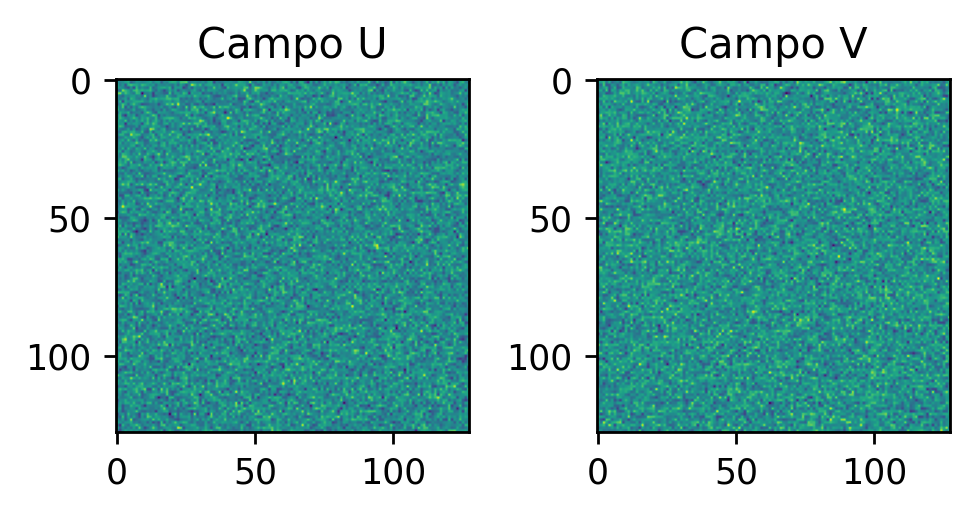

In [7]:
# Podemos probar los campos iniciales
inicializar()
fig, ax = plt.subplots(1, 2, figsize=(4, 4), dpi=250)
ax[0].imshow(u, cmap='viridis')
ax[1].imshow(v, cmap='viridis')
# Seteamos los títulos
ax[0].set_title('Campo U')
ax[1].set_title('Campo V')
plt.tight_layout()
plt.show()

# Función para actualizar el sistema a cada dt

In [8]:
@nb.jit(nopython=True)
def actualizar(u, v, nextu, nextv, lapu, lapv):

    # Calculamos el laplaciano de u y v
    laplaciano_PBC(u, N, dh2_inv, lapu)
    laplaciano_PBC(v, N, dh2_inv, lapv)

    # Actualizamos los campos u y v
    nextu = u + dt * (Du * lapu + alpha * (u - h) + beta * (v - k))
    nextv = v + dt * (Dv * lapv + gamma * (u - h) + delta * (v - k))

    # Actualizamos los campos u y v
    u, nextu = nextu, u
    v, nextv = nextv, v

    return u, v, nextu, nextv

# Simulacion del sistema

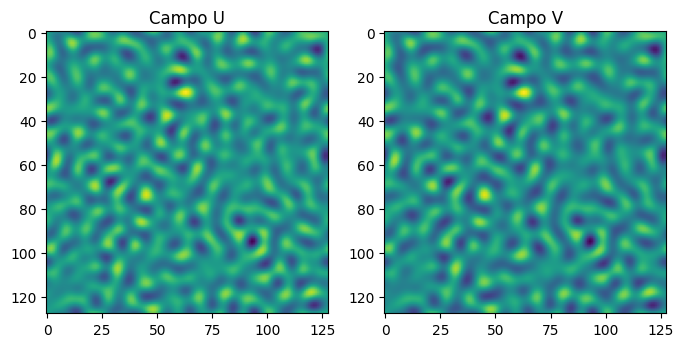

In [9]:
# Crearemos una carpeta para guardar las imágenes
if not os.path.exists('imagenesTuring'):
    os.mkdir('imagenesTuring')

# Primero, inicializamos los campos
inicializar()

# Creamos una figura
fig, ax = plt.subplots(1, 2, figsize=(8, 8), dpi=100)

# Iteramos sobre el tiempo
for i in range(T):
    # Actualizamos los campos
    u, v, nextu, nextv = actualizar(u, v, nextu, nextv, lapu, lapv)

    # Cada 20 iteraciones, guardamos una imagen
    if i % 20 == 0:
        ax[0].imshow(u, cmap='viridis')
        ax[1].imshow(v, cmap='viridis')
        ax[0].set_title('Campo U')
        ax[1].set_title('Campo V')
        plt.savefig('imagenesTuring/{:04d}.png'.format(i // 10))

## Guardamos un video de la simulación

In [10]:
# Primero recopilamos todos los nombres de los archivos en la carpeta imagenesTuring
files = []
for filename in os.listdir('imagenesTuring'):
    if filename.endswith('.png'):
        files.append('imagenesTuring/' + filename)

# Ordenamos los nombres de los archivos
files.sort()

# Creamos el video con Imageio
import imageio
with imageio.get_writer('turing.mp4', fps=15) as writer:
    for filename in files:
        image = imageio.imread(filename)
        writer.append_data(image)

<ipython-input-10-1ddb7c1c4595>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# Tarea 1B. Patrones espaciales

Para esta tarea, deberán implementar un sistema de ecuaciones de reacción-difusión en dos dimensiones. El sistema de ecuaciones es el siguiente:

$$
\begin{align}
\frac{\partial u }{\partial t} &= D_u \nabla^2 u + f(u,v) \\
\frac{\partial v }{\partial t} &= D_v \nabla^2 v + g(u,v)
\end{align}
$$

Donde las funciones $f(u,v)$ y $g(u,v)$ son las siguientes:

$$
\begin{align}
f(u,v) &= u - u^3 - v + k\\
g(u,v) &= \frac{u - v}{\tau}
\end{align}
$$

Donde $f$, $q$, $D_u$ y $D_v$ son constantes. Para este caso, se utilizarán los siguientes valores:

$$
\begin{align}
f &= 1.0 \\
q &= 10^{-3} \\
D_u &= 10^{-4} \\
D_v &= 10^{-4}
\end{align}
$$

Para implementar el sistema se les recomienda utilizar el código previo que está en este cuadernillo, y además les incluimos la funcion de inicialización del sistema. Las partes que deben implementar se detallan con signos de interrrogación.

Tip:

El sistema de ecuaciones que deben implementar es el siguiente:

$$
\begin{align}
\frac{\partial u }{\partial t} &= D_u \nabla^2 u + u - u^3 - v + k\\
\frac{\partial v }{\partial t} &= \frac{D_v \nabla^2 v + u - v}{\tau}
\end{align}
$$

In [ ]:
# ------------------------------------------------------------
# Parámetros del espacio de simulación
# ------------------------------------------------------------
# Tamaño de la malla
N = 100
# Tamaño del sistema
L = 2
# Paso espacial
dh = L / N
# Paso espacial al cuadrado
dh2 = dh * dh
# Inverso del paso espacial al cuadrado
dh2_inv = 1.0 / dh2

In [ ]:
inicialesx, inicialesy = np.meshgrid(np.arange(0, L, dh), np.arange(0, L, dh))

def inicializar():
    global u, v, nextu, nextv, lapu, lapv

    # Inicializamos los campos u y v con ruido aleatorio
    u = np.random.rand(N, N)
    v = np.random.rand(N, N)

    # Inicializamos los campos nextu y nextv con ceros
    nextu = np.zeros((N, N))
    nextv = np.zeros((N, N))

    # Además los arreglos donde guardaremos los laplacianos
    lapu = np.zeros((N, N))
    lapv = np.zeros((N, N))

In [ ]:
# Definimos los parámetros del sistema (ESTOS LOS PUEDEN VARIAR Y OBSERVAR QUÉ LE PASA AL SISTEMA)
k = -0.005
tau = 0.1
Du = 2.8e-4
Dv = 5e-3

# Definimos la función de reacción
@nb.jit(nopython=True)
def reaccion(u, v, nextu, nextv, lapu, lapv):

    # Calcular el laplaciano de u y v
    ?
    ?

    # Actualicen los campos u y v
    ?
    ?

    # Actualizamos los campos para la siguiente iteración
    ?
    ?

    return ?, ?, ?, ?

In [ ]:
# ------------------------------------------------------------
# Parámetros de la simulación
# ------------------------------------------------------------
# Paso temporal
dt = 0.001
# Tiempo total de simulación
T = 10000

In [ ]:
# Verificamos si existe un directorio para las imágenes
if not os.path.exists('imagenesTarea'):
    os.mkdir('imagenesTarea')

# Primero, inicializamos los campos
inicializar()

# Creamos una figura
fig, ax = plt.subplots(1, 2, figsize=(8, 8), dpi=100)

# Iteramos sobre el tiempo
for i in range(T):
    # Actualizamos los campos
    u, v, nextu, nextv = reaccion(u, v, nextu, nextv, lapu, lapv)

    # Cada 50 iteraciones, guardamos una imagen e imprimimos que vamos en el tiempo i del total T
    if i % 50 == 0:
        ax[0].imshow(u, cmap='viridis')
        ax[1].imshow(v, cmap='viridis')
        ax[0].set_title('Campo U')
        ax[1].set_title('Campo V')
        plt.savefig('imagenesTarea/{:04d}.png'.format(i // 10))
        print('Iteración {:04d} de {:04d}'.format(i, T))

In [ ]:
# Primero recopilamos todos los nombres de los archivos en la carpeta imagenesTuring
files = []
for filename in os.listdir('imagenesTarea'):
    if filename.endswith('.png'):
        files.append('imagenesTarea/' + filename)

# Ordenamos los nombres de los archivos
files.sort()

# Creamos el video con Imageio
import imageio
with imageio.get_writer('videoTarea.mp4', fps=10) as writer:
    for filename in files:
        image = imageio.imread(filename)
        writer.append_data(image)